# Programming Exercise 6: Support Vector Machines

# 1 Support Vector Machines

# 1.1 Example Dataset 1

scikit-learn 的 SVC 应该是不需要加截距的（根据官方文档上的例子），所以在处理 X 的时候不需要加上 x0 = 1 一列

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

mat = loadmat('data/ex6data1.mat')
X, y = mat['X'], mat['y']
y = y[:, 0]

X.shape, y.shape

((51, 2), (51,))

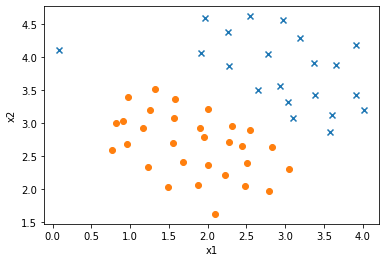

In [83]:
def plot_x1x2(X, y, labels=['', '']):
    data = pd.DataFrame(np.concatenate((X, y[:, None]), axis=1), columns='x1 x2 y'.split())
    positive = data[data['y'] == 1]
    negative = data[data['y'] == 0]
    plt.scatter(positive['x1'], positive['x2'], marker='x')
    plt.scatter(negative['x1'], negative['x2'], marker='o')
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.show()

plot_x1x2(X, y, labels='x1 x2'.split())

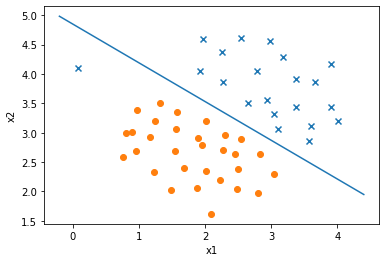

In [84]:
from sklearn import svm

def plot_boundary(theta, xlim):
    """Only for linear boundary"""
    x = np.linspace(*xlim, num=10)
    y = (-theta[0] - theta[1] * x) / theta[2]
    plt.plot(x, y)

def plot_boundary2d(clf, xlim, ylim):
    """Only any boundary"""
    pt = 100
    x_plot = np.linspace(*xlim, pt)
    y_plot = np.linspace(*ylim, pt)
    xm, ym = np.meshgrid(x_plot, y_plot)
    zm = clf.predict_proba(np.concatenate((xm.flatten()[:, None], ym.flatten()[:, None]), axis=1))[:, 1].reshape(xm.shape)

    plt.contour(xm, ym, zm, levels=[0.5])


# C = 1
clf = svm.SVC(C=1, kernel='linear')
clf.fit(X, y)

plot_boundary(theta=[clf.intercept_] + clf.coef_[0, :].tolist(), xlim=(-0.2, 4.4))
plot_x1x2(X, y, labels='x1 x2'.split())

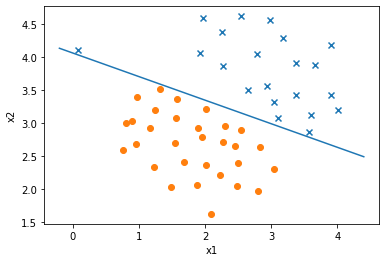

In [85]:
# C = 100
clf = svm.SVC(C=100, kernel='linear')
clf.fit(X, y)

plot_boundary(theta=[clf.intercept_] + clf.coef_[0, :].tolist(), xlim=(-0.2, 4.4))
plot_x1x2(X, y, labels='x1 x2'.split())

# 1.2 SVM with Gaussian Kernels

In [86]:
def gaussian(x1, x2, sigma):
    return np.exp(-1 * ((x1 - x2) ** 2).sum() / 2 / sigma ** 2)

def get_gaussian_kernel(sigma):
    def gk(X1, X2):
        n1, n2 = X1.shape[0], X2.shape[0]
        return np.array([gaussian(X1[i, :], X2[j, :], sigma) for i in range(n1) for j in range(n2)]).reshape((n1, n2))
    return gk

gaussian(np.array([1, 2, 1]), np.array([0, 4, -1]), 2), get_gaussian_kernel(2)(X, X).shape

(0.32465246735834974, (51, 51))

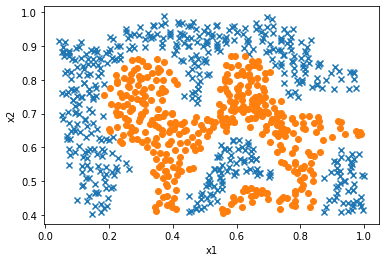

In [87]:
mat = loadmat('data/ex6data2.mat')
X2, y2 = mat['X'], mat['y']
y2 = y2[:, 0]

plot_x1x2(X2, y2, labels='x1 x2'.split())

一开始 sigma = 2，导致不论 C 设定为 1、10、100，效果都不好，欠拟合，将 sigma 改成 0.1，效果一下就上来了

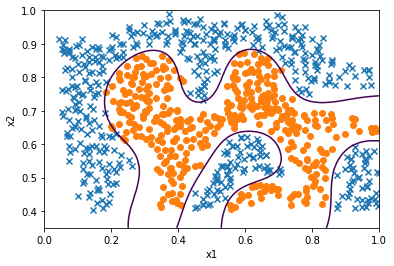

In [88]:
clf = svm.SVC(C=1, kernel=get_gaussian_kernel(sigma=0.1), probability=True)
clf.fit(X2, y2)

plot_boundary2d(clf, (0, 1), (0.35, 1))
plot_x1x2(X2, y2, labels='x1 x2'.split())

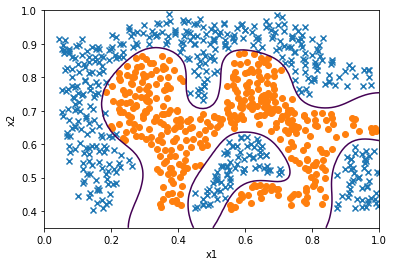

In [89]:
clf = svm.SVC(C=100, kernel=get_gaussian_kernel(sigma=0.1), probability=True)
clf.fit(X2, y2)

plot_boundary2d(clf, (0, 1), (0.35, 1))
plot_x1x2(X2, y2, labels='x1 x2'.split())

试用 rbf（Radial Basis Function），速度非常快

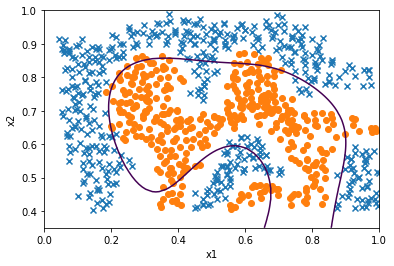

In [90]:
clf = svm.SVC(C=1, kernel='rbf', probability=True)
clf.fit(X2, y2)

plot_boundary2d(clf, (0, 1), (0.35, 1))
plot_x1x2(X2, y2, labels='x1 x2'.split())

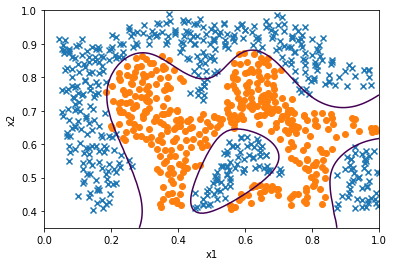

In [91]:
clf = svm.SVC(C=100, kernel='rbf', probability=True)
clf.fit(X2, y2)

plot_boundary2d(clf, (0, 1), (0.35, 1))
plot_x1x2(X2, y2, labels='x1 x2'.split())

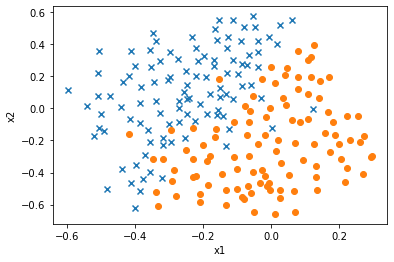

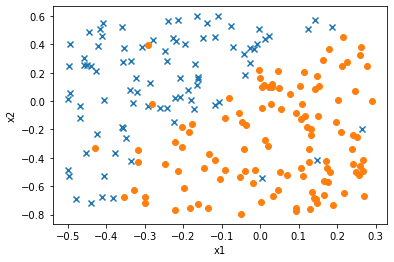

In [92]:
mat = loadmat('data/ex6data3.mat')
X3, y3, X3val, y3val = mat['X'], mat['y'], mat['Xval'], mat['yval']
y3, y3val = y3[:, 0], y3val[:, 0]

plot_x1x2(X3, y3, labels='x1 x2'.split())
plot_x1x2(X3val, y3val, labels='x1 x2'.split())

In [93]:
accurancies = []

for C in (0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30):
    for sigma in (0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30):
        clf = svm.SVC(C=C, kernel=get_gaussian_kernel(sigma=sigma), probability=True)
        clf.fit(X3, y3)
        accurancies.append([C, sigma, 1 - np.abs(clf.predict(X3val).astype(int) - y3val.astype(int)).mean()])

accurancies = np.array(accurancies)

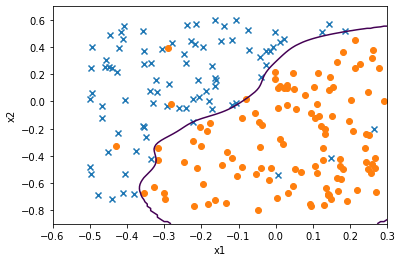

In [94]:
C_max, sigma_max = accurancies[accurancies[:, 2].argmax(), :2] # just get the first largest one
C, sigma = C_max, sigma_max
clf = svm.SVC(C=C, kernel=get_gaussian_kernel(sigma=sigma), probability=True)
clf.fit(X3, y3)
plot_boundary2d(clf, (-0.6, 0.3), (-0.9, 0.7))
plot_x1x2(X3val, y3val, labels='x1 x2'.split())

# 2 Spam Classification

# 2.1 Preprocessing Emails

# 2.2 Extracting Features from Emails

In [95]:
import re
from nltk.stem.porter import PorterStemmer

vocabulary = pd.read_csv('data/vocab.txt', sep='\t', header=None).set_index(1)

def process_email(s):
    # Lower-casing
    s = s.lower()

    # Stripping HTML
    s = s.replace('<', '').replace('>', '')

    # Normalizing URLs
    s = re.sub(r'http(.+)com/', 'httpaddr', s)

    # Normalizing Email Addresses
    s = re.sub(r'(?<=\s)(.+)@(.+)com(?=\s)', 'emailaddr', s)

    # Normalizing Numbers
    s = re.sub(r'\d+', 'number', s)

    # Normalizing Dollars
    s = s.replace('$', 'dollar')

    # Removal of non-words
    s = re.sub(r'\W+', ' ', s).strip()

    # Word Stemming
    st = PorterStemmer() # Porter is the best
    s = ' '.join(st.stem(word) for word in s.split())

    # Get word indices from vocabulary list
    indices = []
    for word in s.split():
        try:
            indices.append(vocabulary.loc[word, 0])
        except:
            pass

    vector = [1 if index + 1 in indices else 0 for index in range(len(vocabulary))]
    return np.array(vector)

text = '''> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors youre expecting. This can be anywhere from less than 10 bucks a month to a couple of $100. You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if youre running something big..
To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com
'''

vector = process_email(text)
vector, vector.shape, vector.sum()

(array([0, 0, 0, ..., 0, 0, 0]), (1899,), 44)

# 2.3 Training SVM for Spam Classification

In [107]:
mat = loadmat('data/spamTrain.mat')
Xtrain, ytrain = mat['X'], mat['y']
ytrain = ytrain[:, 0]

mat = loadmat('data/spamTest.mat')
Xtest, ytest = mat['Xtest'], mat['ytest']
ytest = ytest[:, 0]

Xtrain.shape, ytrain.shape, Xtest.shape, ytrain.shape

((4000, 1899), (4000,), (1000, 1899), (4000,))

In [109]:
# C = 1
clf = svm.SVC(C=1, kernel='linear')
clf.fit(Xtrain, ytrain)
accuracy_train = 1 - np.abs(clf.predict(Xtrain).astype(int) - ytrain.astype(int)).mean()
accuracy_test = 1 - np.abs(clf.predict(Xtest).astype(int) - ytest.astype(int)).mean()
accuracy_train, accuracy_test

(0.99975, 0.978)

In [110]:
# C = 0.1
clf = svm.SVC(C=0.1, kernel='linear')
clf.fit(Xtrain, ytrain)
accuracy_train = 1 - np.abs(clf.predict(Xtrain).astype(int) - ytrain.astype(int)).mean()
accuracy_test = 1 - np.abs(clf.predict(Xtest).astype(int) - ytest.astype(int)).mean()
accuracy_train, accuracy_test

(0.99825, 0.989)

# 2.4 Top Predictors for Spam

In [143]:
vocabulary = vocabulary.reset_index()
vocabulary.columns = 'word number'.split()
vocabulary['coef'] = clf.coef_[0, :]
vocabulary = vocabulary.sort_values('coef', ascending=False)
vocabulary.head(20)

,word,number,coef
1190,our,1191,0.500614
297,click,298,0.465916
1397,remov,1398,0.422869
738,guarante,739,0.383622
1795,visit,1796,0.367710
155,basenumb,156,0.345064
476,dollar,477,0.323632
1851,will,1852,0.269724
1298,price,1299,0.267298
1263,pleas,1264,0.261169
